In this notebook, we will fine-tune Idefics2 with LoRA. We will replace every linear layer in the LLM with a LoRA adapter layer.

We start by importing the ScienceQA dataset from HuggingFace. The answers are given as integers but we have to transform them into strings to fine-tune the model.

c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=202x202>,
 'question': "Which animal's feet are also adapted for grabbing prey?",
 'choices': ['sable', 'New Zealand falcon'],
 'answer': '1',
 'hint': "Bald eagles eat fish, mammals, and other birds. The 's feet are adapted for grabbing prey.\nFigure: bald eagle.",
 'task': 'closed choice',
 'grade': 'grade5',
 'subject': 'natural science',
 'topic': 'biology',
 'category': 'Adaptations',
 'skill': 'Animal adaptations: feet and limbs',
 'lecture': "An adaptation is an inherited trait that helps an organism survive or reproduce. Adaptations can include both body parts and behaviors.\nThe shape of an animal's feet is one example of an adaptation. Animals' feet can be adapted in different ways. For example, webbed feet might help an animal swim. Feet with thick fur might help an animal walk on cold, snowy ground.",
 'solution': 'Look at the picture of the bald eagle.\nThe bald eagle has long toes with sharp claws. Its feet ar

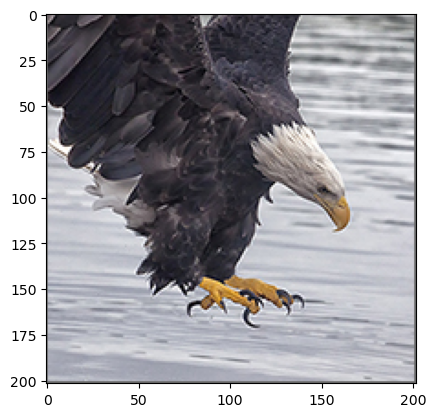

In [2]:
from datasets import load_dataset, Value
import matplotlib.pyplot as plt

ds = load_dataset("derek-thomas/ScienceQA")
ds = ds.filter(lambda example: example['image'] is not None) #only keep obs with images
ds = ds.cast_column('answer', Value("string")) #convert answer from int to string

# Show an example
example = ds['validation'][3]
plt.imshow(example['image'])#.resize((100, 100), Image.Resampling.LANCZOS))
example

Next we define the train and validation datasets.

In [3]:
train_dataset = ds['train']
train_dataset = train_dataset.remove_columns(['hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'])

eval_dataset = ds['validation']
eval_dataset = eval_dataset.remove_columns(['hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'])

Question: Which term matches the picture?
Choices: ['appendicular skeleton', 'axial skeleton']
Answer: 1


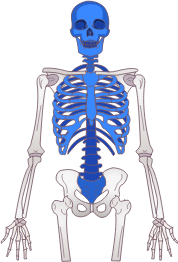

In [4]:
val_example = eval_dataset[16]
image, question, choices, answer = val_example['image'], val_example['question'], val_example['choices'], val_example['answer']
print("Question:", question)
print("Choices:", choices)
print("Answer:", answer)
image

We load in the Idefics2 model and processor from HuggingFace. We use the version with 8b parameters to have a model small enough to fit on consumer hardware. We will also quantize the model (store it in a 4-bit format) to reduce the memory overhead.

In [5]:
from transformers import AutoProcessor, AutoTokenizer, Idefics2ForConditionalGeneration, BitsAndBytesConfig
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Load in the processor which formats inputs for Idefics
processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False, size= {"longest_edge": 448, "shortest_edge": 378})
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

# Tokenizer
IDEFICS2_CHAT_TEMPLATE = """{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. {% for message in messages %}{% if message['role'] == 'user' %}USER: {% else %}ASSISTANT: {% endif %}{% for item in message['content'] %}{% if item['type'] == 'text' %}{{ item['text'] }}{% elif item['type'] == 'image' %}<image>{% endif %}{% endfor %}{% if message['role'] == 'user' %} {% else %}{{eos_token}}{% endif %}{% endfor %}{% if add_generation_prompt %}ASSISTANT: {% endif %}"""
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceM4/idefics2-8b", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.chat_template = IDEFICS2_CHAT_TEMPLATE

# We will us QLoRa, so we specify how to quantize the model
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = Idefics2ForConditionalGeneration.from_pretrained("HuggingFaceM4/idefics2-8b",
                                                         torch_dtype=torch.float16,
                                                         quantization_config=quantization_config).to(device)



cuda


Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 7/7 [00:56<00:00,  8.08s/it]
You shouldn't move a model that is dispatched using accelerate hooks.


Now that the model is loaded in, we identify every linear layer of the model and add the LoRa adapter layers. These layers will be trained in place of the model. We will use a rank of 8. Higher ranks should result in better perfomance but increase the number of trainable parameters.

In [6]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model


def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    # target_modules=find_all_linear_names(model),
    target_modules=".*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$",
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

Examine the number of trainable parameters.

In [12]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param}"
    )

In [13]:
print_trainable_parameters(model)

trainable params: 23,326,720 || all params: 4,359,440,624 || trainable%: 0.535085163715261


Before we start fine-tuning, we must define the collate function. This will inform the trainer how to batch training examples. We format the question, choices, and answer of each observations into a prompt format the the model accepts. 

In [ ]:
class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = example["image"]
            if image is None:
                continue
            question = example["question"]
            choices = example["choices"]
            answer = example["answer"]

            content = [{"type": "text", "text": "Please read the multiple-choice question below carefully and answer only with an index of the given list of choices."}]
            content += [{"type": "image"}]
            content += [{"type": "text", "text": f"{question}\nThe choices are: {choices}."}]

            messages = [
                {
                    "role": "user",
                    "content": content,
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images, return_tensors="pt", padding=True, max_length=512)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.image_token_id
        batch["labels"] = labels

        return batch

data_collator = MyDataCollator(processor)

We verify that the data collator works as intended.

In [8]:
batch = data_collator.__call__((train_dataset[0], train_dataset[1]))

c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [9]:
processor.batch_decode(batch['input_ids'])

["<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><s> User: Please read the multiple-choice question below carefully and answer only with an index of the given list of choices.<fake_token_around_image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><fake_token_around_image> Which of these states is farthest north?\nThe choices are: ['West Virginia', 'Louisiana', 'Arizona', 'Oklahoma'].<end_of_utterance> \

Now we can define the parameters for fine-tuning and train the model. Due to time and memory constraints, we will only train the model for 2 epochs and use a batch size of 2. However, we accumulate the gradients over 8 steps. This results in an effective batch size of 16.

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    output_dir="Idefics2_qlora_ft",
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    # evaluation_strategy="epoch",
    fp16=True,
    push_to_hub=False,
    remove_unused_columns=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    # eval_dataset=eval_dataset, # You can also evaluate (loss) on the eval set, note that it will incur some additional GPU memory
)

In [11]:
trainer.train()

  0%|          | 0/776 [00:00<?, ?it/s]c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
  3%|▎         | 25/776 [11:34<5:57:19, 28.55s/it]

{'loss': 6.1959, 'grad_norm': 73.52931213378906, 'learning_rate': 4e-05, 'epoch': 0.06}


  6%|▋         | 50/776 [24:54<6:43:25, 33.34s/it]

{'loss': 0.242, 'grad_norm': 35.9378547668457, 'learning_rate': 8.6e-05, 'epoch': 0.13}


 10%|▉         | 75/776 [38:53<6:44:21, 34.61s/it]

{'loss': 0.1547, 'grad_norm': 17.20689582824707, 'learning_rate': 9.75206611570248e-05, 'epoch': 0.19}


 13%|█▎        | 100/776 [53:10<6:34:53, 35.05s/it]

{'loss': 0.1469, 'grad_norm': 20.287986755371094, 'learning_rate': 9.40771349862259e-05, 'epoch': 0.26}


c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 16%|█▌        | 125/776 [1:08:13<6:30:59, 36.04s/it]

{'loss': 0.1286, 'grad_norm': 13.42410659790039, 'learning_rate': 9.063360881542701e-05, 'epoch': 0.32}


 19%|█▉        | 150/776 [1:20:50<5:03:17, 29.07s/it]

{'loss': 0.1098, 'grad_norm': 19.16493797302246, 'learning_rate': 8.71900826446281e-05, 'epoch': 0.39}


 23%|██▎       | 175/776 [1:32:25<4:38:01, 27.76s/it]

{'loss': 0.1161, 'grad_norm': 13.091551780700684, 'learning_rate': 8.374655647382921e-05, 'epoch': 0.45}


 26%|██▌       | 200/776 [1:44:28<4:37:20, 28.89s/it]

{'loss': 0.1034, 'grad_norm': 10.621013641357422, 'learning_rate': 8.03030303030303e-05, 'epoch': 0.51}


c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 29%|██▉       | 225/776 [1:56:02<4:20:35, 28.38s/it]

{'loss': 0.1055, 'grad_norm': 14.146879196166992, 'learning_rate': 7.685950413223141e-05, 'epoch': 0.58}


 32%|███▏      | 250/776 [2:07:45<4:00:12, 27.40s/it]

{'loss': 0.1007, 'grad_norm': 11.99414348602295, 'learning_rate': 7.341597796143251e-05, 'epoch': 0.64}


 35%|███▌      | 275/776 [2:19:34<3:50:51, 27.65s/it]

{'loss': 0.0924, 'grad_norm': 8.654071807861328, 'learning_rate': 6.99724517906336e-05, 'epoch': 0.71}


 39%|███▊      | 300/776 [2:31:25<3:39:33, 27.68s/it]

{'loss': 0.0873, 'grad_norm': 9.554022789001465, 'learning_rate': 6.652892561983471e-05, 'epoch': 0.77}


c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
 42%|████▏     | 325/776 [2:43:13<3:27:46, 27.64s/it]

{'loss': 0.0924, 'grad_norm': 11.172882080078125, 'learning_rate': 6.308539944903582e-05, 'epoch': 0.84}


 45%|████▌     | 350/776 [2:55:00<3:20:08, 28.19s/it]

{'loss': 0.0928, 'grad_norm': 8.639358520507812, 'learning_rate': 5.9641873278236915e-05, 'epoch': 0.9}


 48%|████▊     | 375/776 [3:06:48<3:10:10, 28.45s/it]

{'loss': 0.0848, 'grad_norm': 7.10936975479126, 'learning_rate': 5.619834710743802e-05, 'epoch': 0.96}


 52%|█████▏    | 400/776 [3:18:32<2:56:08, 28.11s/it]

{'loss': 0.0834, 'grad_norm': 8.124177932739258, 'learning_rate': 5.275482093663911e-05, 'epoch': 1.03}


c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
 55%|█████▍    | 425/776 [3:30:20<2:46:38, 28.49s/it]

{'loss': 0.064, 'grad_norm': 9.578630447387695, 'learning_rate': 4.931129476584022e-05, 'epoch': 1.09}


 58%|█████▊    | 450/776 [3:42:18<2:41:24, 29.71s/it]

{'loss': 0.0644, 'grad_norm': 8.764467239379883, 'learning_rate': 4.586776859504133e-05, 'epoch': 1.16}


 61%|██████    | 475/776 [3:54:02<2:22:30, 28.41s/it]

{'loss': 0.0649, 'grad_norm': 14.295671463012695, 'learning_rate': 4.242424242424243e-05, 'epoch': 1.22}


 64%|██████▍   | 500/776 [4:06:01<2:11:45, 28.64s/it]

{'loss': 0.06, 'grad_norm': 13.872583389282227, 'learning_rate': 3.898071625344353e-05, 'epoch': 1.29}


c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
 68%|██████▊   | 525/776 [4:17:52<1:56:37, 27.88s/it]

{'loss': 0.0657, 'grad_norm': 9.728997230529785, 'learning_rate': 3.553719008264463e-05, 'epoch': 1.35}


 71%|███████   | 550/776 [4:29:39<1:48:37, 28.84s/it]

{'loss': 0.0635, 'grad_norm': 9.50090217590332, 'learning_rate': 3.209366391184573e-05, 'epoch': 1.42}


 74%|███████▍  | 575/776 [4:41:32<1:34:27, 28.19s/it]

{'loss': 0.0629, 'grad_norm': 6.416575908660889, 'learning_rate': 2.8650137741046835e-05, 'epoch': 1.48}


 77%|███████▋  | 600/776 [4:53:20<1:24:30, 28.81s/it]

{'loss': 0.0628, 'grad_norm': 6.655036449432373, 'learning_rate': 2.5206611570247934e-05, 'epoch': 1.54}


c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
 81%|████████  | 625/776 [5:05:10<1:13:35, 29.24s/it]

{'loss': 0.0641, 'grad_norm': 5.839641571044922, 'learning_rate': 2.1763085399449036e-05, 'epoch': 1.61}


 84%|████████▍ | 650/776 [5:16:53<58:26, 27.83s/it]  

{'loss': 0.0599, 'grad_norm': 4.605925559997559, 'learning_rate': 1.8319559228650138e-05, 'epoch': 1.67}


 87%|████████▋ | 675/776 [5:28:55<51:02, 30.32s/it]

{'loss': 0.0608, 'grad_norm': 6.463035583496094, 'learning_rate': 1.487603305785124e-05, 'epoch': 1.74}


 90%|█████████ | 700/776 [5:41:59<38:21, 30.29s/it]

{'loss': 0.0613, 'grad_norm': 6.58440637588501, 'learning_rate': 1.1432506887052343e-05, 'epoch': 1.8}


c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\philg\anaconda3\envs\cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
 93%|█████████▎| 725/776 [5:53:43<24:07, 28.38s/it]

{'loss': 0.0583, 'grad_norm': 6.306910514831543, 'learning_rate': 7.988980716253445e-06, 'epoch': 1.87}


 97%|█████████▋| 750/776 [6:05:33<12:18, 28.40s/it]

{'loss': 0.0552, 'grad_norm': 6.768148899078369, 'learning_rate': 4.5454545454545455e-06, 'epoch': 1.93}


100%|█████████▉| 775/776 [6:17:25<00:28, 28.41s/it]

{'loss': 0.0589, 'grad_norm': 8.389741897583008, 'learning_rate': 1.1019283746556475e-06, 'epoch': 2.0}


100%|██████████| 776/776 [6:17:53<00:00, 29.22s/it]

{'train_runtime': 22673.9853, 'train_samples_per_second': 0.548, 'train_steps_per_second': 0.034, 'train_loss': 0.28562152957946985, 'epoch': 2.0}


TrainOutput(global_step=776, training_loss=0.28562152957946985, metrics={'train_runtime': 22673.9853, 'train_samples_per_second': 0.548, 'train_steps_per_second': 0.034, 'total_flos': 9.11006932034306e+16, 'train_loss': 0.28562152957946985, 'epoch': 1.9977484721775491})